In [453]:
import numpy as np
import json
import random
import argparse
import os

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.distributions.multivariate_normal as mvn
from torch.nn.utils import spectral_norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

In [454]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [455]:
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


In [456]:
# batch_size = args.batch_size
# lrd = args.learning_rate_disc
# lrg = args.learning_rate_gen
# epochs = args.epochs

batch_size = 256
lr = 1e-4
epochs = 10

betas = [0.5, 0.999]

# Check for cuda
use_cuda = torch.cuda.is_available()

EPS = 1e-6

In [457]:
class Encoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128, hidden_dim=64, z=10):
        super(Encoder, self).__init__()

        self.num_hiddens = num_hiddens
        self.z = z

        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._fc1 = nn.Linear(1024, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z)
        self.fc_logvar = nn.Linear(hidden_dim, self.z)
        #self.fc_theta = nn.Linear(hidden_dim, self.z) 
        
    def forward(self, inputs):

        x1 = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)

        x2 = self._conv_1(x1)
        x2 = F.leaky_relu(x2, 0.2, inplace=True)

        x3 = self._conv_2(x2)
        x3 = F.leaky_relu(x3, 0.2, inplace=True)

        x4 = self._conv_3(x3)
        x4 = F.leaky_relu(x4, 0.2, inplace=True)

        x5 = self._fc1(x4.view(-1, self.num_hiddens*8))
        x5 = F.leaky_relu(x5, 0.2, inplace=True)

        mean = self.fc_mean(x5)
        logvar = self.fc_logvar(x5)
        return mean, logvar

In [458]:
class Decoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(Decoder, self).__init__()

        self.num_hiddens = num_hiddens

        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)

        self._fc2 = nn.Linear(hidden_dim//2, 1024)

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)

        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)


        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv2(x.view(-1,64,4,4))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv4(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        return torch.sigmoid(self._tconv5(x))

In [459]:
class VAE(nn.Module):
    def __init__(self, img_size = (1,64,64), enc_hidden = 256, hidden_dim = 64, dis_hidden = 32, z = 5, dec_hidden = 256, use_cuda=False):

        super(VAE, self).__init__()
        self.use_cuda = use_cuda

        # Parameters
        self.img_size = img_size
        self.num_pixels = img_size[0] * img_size[1] * img_size[2]
        self.z = z
        self.channels = img_size[0]

        # Define the encoder
        self.img_to_features = Encoder(in_channels=self.channels, hidden_dim=hidden_dim, z=self.z)

        # Define decoder
        self.features_to_img = Decoder(self.z, out_channels=self.channels)

    def forward(self, data):
        mean, logvar = self.encode(data)
        sample = self.reparameterize([mean, logvar])
        recons = self.decode(sample)
        return recons, [mean, logvar]
    
    def encode(self,data):
        return self.img_to_features(data)
    
    def decode(self,data):
        return self.features_to_img(data)
        
    def representation_function(self,x):
        mean, logvar = self.img_to_features(x)
        return mean

    def reparameterize(self, latent_disc):
        mean, logvar = latent_disc
        std = torch.exp(0.5 * logvar)
        eps = torch.zeros(std.size()).normal_()
        if self.use_cuda:
            eps = eps.cuda()
        return mean + std * eps

In [460]:
if __name__ == "__main__":
    batch_size = 256
    img_size = (1,64,64)
    z=10
    model = VAE(img_size=img_size, z=z, use_cuda=use_cuda)
    if use_cuda:
        model.cuda()
    checkpoint = torch.load('../resultsnpair/realdetmulabssupconweights_e50_z10_b1_g0_lr[0.0005, 0.0005, 0.0001]_bs128_s1123_r[10, 0, 10, 0]_d3',map_location=torch.device('cpu'))
    plots = ['samples', 'reconstruct-traverse']
    loss_file = '../resultsnpair/realdetmulabssupconlosses_e50_z10_b1_g0_lr[0.0005, 0.0005, 0.0001]_bs128_s1123_r[10, 0, 10, 0]_d3.json'

    
    
    #

In [461]:
## see if this can be used 

# test_data = torch.from_numpy(np.load('tinydsprites_s1_o_y.npy')).float()
test_data = torch.from_numpy(np.load('../dsprites/dsprites_data_test.npy')).unsqueeze(1).float()
test_labels = torch.from_numpy(np.load('../dsprites/dsprites_latent_values_test.npy')).float()
# test_labels = torch.from_numpy(np.load('tinydsplabels_s1_o.npy')).float()


test_dataset = torch.utils.data.TensorDataset(test_data,test_labels)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True,
drop_last=True)


In [462]:
################## yann visualizations ########################################

In [463]:
class Visualizer():
    def __init__(self, model, model_dir, loss_file, 
                 save_images=True,
                 loss_of_interest=None,
                 display_loss_per_dim=False,
                 max_traversal=0.475,  # corresponds to ~2 for standard normal
                 upsample_factor=1):
        """
        Visualizer is used to generate images of samples, reconstructions,
        latent traversals and so on of the trained model.
        Parameters
        ----------
        model : disvae.vae.VAE
        dataset : str
            Name of the dataset.
        model_dir : str
            The directory that the model is saved to and where the images will
            be stored.
        save_images : bool, optional
            Whether to save images or return a tensor.
        loss_of_interest : str, optional
            The loss type (as saved in the log file) to order the latent dimensions by and display.
        display_loss_per_dim : bool, optional
            if the loss should be included as text next to the corresponding latent dimension images.
        max_traversal: float, optional
            The maximum displacement induced by a latent traversal. Symmetrical
            traversals are assumed. If `m>=0.5` then uses absolute value traversal,
            if `m<0.5` uses a percentage of the distribution (quantile).
            E.g. for the prior the distribution is a standard normal so `m=0.45` c
            orresponds to an absolute value of `1.645` because `2m=90%%` of a
            standard normal is between `-1.645` and `1.645`. Note in the case
            of the posterior, the distribution is not standard normal anymore.
        upsample_factor : floar, optional
            Scale factor to upsample the size of the tensor
        """
        self.model = model
        self.device = next(self.model.parameters()).device
        self.latent_dim = self.model.z
        self.max_traversal = max_traversal
        self.save_images = save_images
        self.model_dir = model_dir 
        self.dataset = 'dsprites'
        self.upsample_factor = upsample_factor
        if loss_of_interest is not None:
            # get this from your loss file
            self.losses = read_loss_from_file(loss_file)

    def _get_traversal_range(self, mean=0, std=1):
        """Return the corresponding traversal range in absolute terms."""
        max_traversal = self.max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        # symmetrical traversals
        return (-1 * max_traversal, max_traversal)

    def _traverse_line(self, idx, n_samples, data=None):
        """Return a (size, latent_size) latent sample, corresponding to a traversal
        of a latent variable indicated by idx.
        Parameters
        ----------
        idx : int
            Index of continuous dimension to traverse. If the continuous latent
            vector is 10 dimensional and idx = 7, then the 7th dimension
            will be traversed while all others are fixed.
        n_samples : int
            Number of samples to generate.
        data : torch.Tensor or None, optional
            Data to use for computing the posterior. Shape (N, C, H, W). If
            `None` then use the mean of the prior (all zeros) for all other dimensions.
        """
        if data is None:
            # mean of prior for other dimensions
            samples = torch.zeros(n_samples, self.latent_dim)
            traversals = torch.linspace(*self._get_traversal_range(), steps=n_samples)

        else:
            if data.size(0) > 1:
                raise ValueError("Every value should be sampled from the same posterior, but {} datapoints given.".format(data.size(0)))

            with torch.no_grad():
                post_mean, post_logvar = self.model.encode(data.to(self.device))
                samples = self.model.reparameterize([post_mean, post_logvar])
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

            # travers from the gaussian of the posterior in case quantile
            traversals = torch.linspace(*self._get_traversal_range(mean=post_mean_idx,
                                                                   std=post_std_idx),
                                        steps=n_samples)

        for i in range(n_samples):
            samples[i, idx] = traversals[i]

        return samples

    def _save_or_return(self, to_plot, size, filename, is_force_return=False):
        """Create plot and save or return it."""
        to_plot = F.interpolate(to_plot, scale_factor=self.upsample_factor)

        if size[0] * size[1] != to_plot.shape[0]:
            raise ValueError("Wrong size {} for datashape {}".format(size, to_plot.shape))

        # `nrow` is number of images PER row => number of col
        kwargs = dict(nrow=size[1], pad_value=1)
        if self.save_images and not is_force_return:
            filename = os.path.join(self.model_dir, filename)
            save_image(to_plot, filename, **kwargs)
        else:
            return make_grid_img(to_plot, **kwargs)

    def _decode_latents(self, latent_samples):
        """Decodes latent samples into images.
        Parameters
        ----------
        latent_samples : torch.autograd.Variable
            Samples from latent distribution. Shape (N, L) where L is dimension
            of latent distribution.
        """
        latent_samples = latent_samples.to(self.device)
        return self.model.decode(latent_samples).cpu()

    def generate_samples(self, size=(8, 8)):
        """Plot generated samples from the prior and decoding.
        Parameters
        ----------
        size : tuple of ints, optional
            Size of the final grid.
        """
        prior_samples = torch.randn(size[0] * size[1], self.latent_dim)
        generated = self._decode_latents(prior_samples)
        return self._save_or_return(generated.data, size, PLOT_NAMES["generate_samples"])

    def data_samples(self, data, size=(8, 8)):
        """Plot samples from the dataset
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of the final grid.
        """
        data = data[:size[0] * size[1], ...]
        return self._save_or_return(data, size, PLOT_NAMES["data_samples"])

    def reconstruct(self, data, size=(8, 8), is_original=True, is_force_return=False):
        """Generate reconstructions of data through the model.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of grid on which reconstructions will be plotted. The number
            of rows should be even when `is_original`, so that upper
            half contains true data and bottom half contains reconstructions.contains
        is_original : bool, optional
            Whether to exclude the original plots.
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        if is_original:
            if size[0] % 2 != 0:
                raise ValueError("Should be even number of rows when showing originals not {}".format(size[0]))
            n_samples = size[0] // 2 * size[1]
        else:
            n_samples = size[0] * size[1]

        with torch.no_grad():
            originals = data.to(self.device)[:n_samples, ...]
            recs,_ = self.model(originals)

        originals = originals.cpu()
        recs = recs.view(-1, *self.model.img_size).cpu()

        to_plot = torch.cat([originals, recs]) if is_original else recs
        return self._save_or_return(to_plot, size, PLOT_NAMES["reconstruct"],
                                    is_force_return=is_force_return)

    def traversals(self,
                   data=None,
                   is_reorder_latents=False,
                   n_per_latent=8,
                   n_latents=None,
                   is_force_return=False):
        """Plot traverse through all latent dimensions (prior or posterior) one
        by one and plots a grid of images where each row corresponds to a latent
        traversal of one latent dimension.
        Parameters
        ----------
        data : bool, optional
            Data to use for computing the latent posterior. If `None` traverses
            the prior.
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_reorder_latents : bool, optional
            If the latent dimensions should be reordered or not
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim
        latent_samples = [self._traverse_line(dim, n_per_latent, data=data)
                          for dim in range(self.latent_dim)]
        decoded_traversal = self._decode_latents(torch.cat(latent_samples, dim=0))

        if is_reorder_latents:
            n_images, *other_shape = decoded_traversal.size()
            n_rows = n_images // n_per_latent
            decoded_traversal = decoded_traversal.reshape(n_rows, n_per_latent, *other_shape)
            decoded_traversal = sort_list_by_other(decoded_traversal, self.losses)
            decoded_traversal = torch.stack(decoded_traversal, dim=0)
            decoded_traversal = decoded_traversal.reshape(n_images, *other_shape)
            
        decoded_traversal = decoded_traversal[range(n_per_latent * n_latents), ...]

        size = (n_latents, n_per_latent)
        sampling_type = "prior" if data is None else "posterior"
        filename = "{}_{}".format(sampling_type, PLOT_NAMES["traversals"])

        return self._save_or_return(decoded_traversal.data, size, filename,
                                    is_force_return=is_force_return)

    def reconstruct_traverse(self, data,
                             is_posterior=True,
                             n_per_latent=10,
                             n_latents=None,
                             is_show_text=True):
        """
        Creates a figure whith first row for original images, second are
        reconstructions, rest are traversals (prior or posterior) of the latent
        dimensions.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_posterior : bool, optional
            Whether to sample from the posterior.
        is_show_text : bool, optional
            Whether the KL values next to the traversal rows.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim

        reconstructions = self.reconstruct(data[:2 * n_per_latent, ...],
                                           size=(2, n_per_latent),
                                           is_force_return=True)
        traversals = self.traversals(data=data[2:3, ...] if is_posterior else None,
                                     is_reorder_latents=True,
                                     n_per_latent=n_per_latent,
                                     n_latents=n_latents,
                                     is_force_return=True)

        concatenated = np.concatenate((reconstructions, traversals), axis=0)
        concatenated = Image.fromarray(concatenated)
        concatenated.show()

        if is_show_text:
            losses = sorted(self.losses, reverse=True)[:n_latents]
            labels = ['orig', 'recon'] + ["KL={:.4f}".format(l) for l in losses]
            concatenated = add_labels(concatenated, labels)

        filename = os.path.join(self.model_dir, PLOT_NAMES["reconstruct_traverse"])
        concatenated.save(filename)

In [464]:
def load_weights(model, checkpoint):
    model.img_to_features.load_state_dict(checkpoint['encoder'])
    model.features_to_img.load_state_dict(checkpoint['decoder'])
    model.eval()
    return model

def make_grid_img(tensor, **kwargs):
    """Converts a tensor to a grid of images that can be read by imageio.
    Notes
    -----
    * from in https://github.com/pytorch/vision/blob/master/torchvision/utils.py
    Parameters
    ----------
    tensor (torch.Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    kwargs:
        Additional arguments to `make_grid_img`.
    """
    grid = make_grid(tensor, **kwargs)
    img_grid = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
    img_grid = img_grid.to('cpu', torch.uint8).numpy()
    return img_grid


# def get_samples
def get_samples(dataset, num_samples, idcs=[]):
    """ Generate a number of samples from the dataset.
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    num_samples : int, optional
        The number of samples to load from the dataset
    idcs : list of ints, optional
        List of indices to of images to put at the begning of the samples.
    """
    data_loader = torch.utils.data.DataLoader(dataset,
                                  batch_size=1,
                                  shuffle=idcs is None)

    idcs += random.sample(range(len(data_loader.dataset)), num_samples - len(idcs))
    samples = torch.stack([data_loader.dataset[i][0] for i in idcs], dim=0)
    print("Selected idcs: {}".format(idcs))

    return samples

def sort_list_by_other(to_sort, other, reverse=True):
    """Sort a list by an other."""
    return [el for _, el in sorted(zip(other, to_sort), reverse=reverse)]

def read_loss_from_file(loss_file):
    with open(loss_file) as f:
        data = json.load(f)
    kllist =[]
    for key in list(data):
        if 'kl_' in key:
            if 'kl_z' not in key:
                kllist.append(np.sum(data[key][-100:])/100)
    return kllist

def add_labels(input_image, labels):
    """Adds labels next to rows of an image.
    Parameters
    ----------
    input_image : image
        The image to which to add the labels
    labels : list
        The list of labels to plot
    """
    new_width = input_image.width + 100
    new_size = (new_width, input_image.height)
    new_img = Image.new("RGB", new_size, color='white')
    new_img.paste(input_image, (0, 0))
    draw = ImageDraw.Draw(new_img)

    for i, s in enumerate(labels):
        draw.text(xy=(new_width - 100 + 0.005,
                      int((i / len(labels) + 1 / (2 * len(labels))) * input_image.height)),
                  text=s,
                  fill=(0, 0, 0))

    return new_img

In [465]:
PLOT_NAMES = dict(generate_samples="samples.png",
                  data_samples="data_samples.png",
                  reconstruct="reconstruct.png",
                  traversals="traversals.png",
                  reconstruct_traverse="reconstruct_traverse.png")
n_rows = z
#n_rows = model.latent_dim
n_cols = 10

#model = VAE(img_size=img_size, z1=2, z2=10, use_cuda=use_cuda)
model = load_weights(model, checkpoint)

dataset = 'dsprites'
    
viz = Visualizer(model=model,
                 model_dir='',
                 max_traversal=2,
                 loss_of_interest='kl_loss', loss_file=loss_file,
                 upsample_factor=1) 
size = (n_rows, n_cols)
# same samples for all plots: sample max then take first `x`data  for all plots
num_samples = n_cols * n_rows
    
samples = get_samples(test_dataset, num_samples)
    
if "all" in plots:
    plots = [p for p in PLOT_TYPES if p != "all"]

# mostly call it with reconstruct-traverse

for plot_type in plots:
    if plot_type == 'generate-samples':
        viz.generate_samples(size=size)
    elif plot_type == 'data-samples':
        viz.data_samples(samples, size=size)
    elif plot_type == "reconstruct":
        viz.reconstruct(samples, size=size)
    elif plot_type == "reconstruct-traverse":
        viz.reconstruct_traverse(samples,
                                 is_posterior=True,
                                 n_latents=n_rows,
                                 n_per_latent=n_cols,
                                 is_show_text=True)

Selected idcs: [143, 77, 255, 130, 236, 3, 196, 129, 11, 118, 201, 74, 218, 9, 17, 41, 124, 1, 238, 55, 151, 82, 174, 246, 116, 212, 177, 144, 90, 110, 59, 123, 4, 102, 16, 69, 207, 211, 153, 98, 224, 83, 65, 170, 235, 163, 114, 205, 239, 71, 42, 181, 162, 26, 24, 79, 5, 73, 45, 225, 149, 145, 113, 99, 220, 95, 126, 36, 52, 58, 93, 188, 0, 228, 128, 136, 184, 15, 222, 34, 221, 155, 152, 100, 20, 38, 204, 226, 106, 104, 229, 137, 134, 173, 61, 138, 213, 54, 141, 33]


In [466]:
##### end yann visualizations ##############################################################

In [467]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

model.img_to_features.load_state_dict(checkpoint['encoder'])
model.features_to_img.load_state_dict(checkpoint['decoder'])

model.eval()

(valid_originals, labels) = next(iter(test_loader))
valid_originals = valid_originals.to(device)
latent_dist = model.encode(valid_originals)
latent_sample = latent_dist[0]
valid_reconstructions = model.decode(latent_sample)

In [468]:
# c = 0
# import matplotlib.pyplot as plt
# plt.scatter(latent_dist[c][0].detach().numpy(), latent_dist[c][1].detach().numpy()) 
# #             c = labels[:,0,5].detach().numpy().tolist())
# # plt.scatter(latent_dist[c][1].detach().numpy(), np.zeros((32,)), 
# #             c = labels[:,0,5].detach().numpy().tolist())

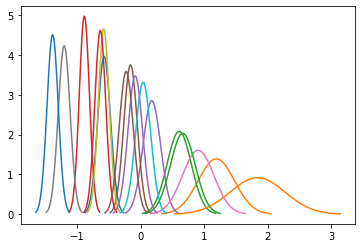

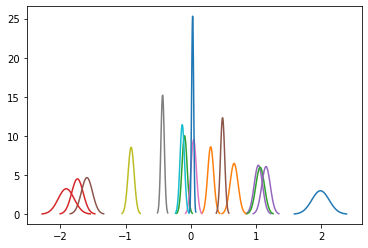

In [469]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


lat=4
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.xlim([-2,2])
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,5].detach().numpy().tolist(),0.2,0.5))
plt.show()
lat=5
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,3].detach().numpy().tolist(),0.2,0.5))
plt.show()

In [470]:
# print(latent_dist[1])

In [471]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    #return fig

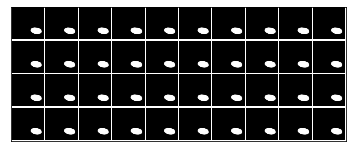

In [472]:
samp = latent_sample[0]
s = samp.repeat(40,1)

b = torch.linspace(-2,2,40)
s[:,9] = b.view(40,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

### s = samp.repeat(10,1)

b = torch.linspace(-1,2,10)
s[:,9] = b.view(10,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

In [473]:
# s = samp.repeat(40,1)
# s[:,4] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [474]:
# s = samp.repeat(40,1)
# s[:,7] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [475]:
# s = samp.repeat(40,1)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [476]:
def show_images_grid(imgs_, num_images=128):
    imgs_ = imgs_.numpy()
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

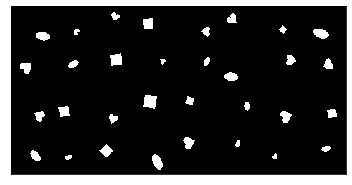

In [477]:
show(vutils.make_grid(valid_originals.cpu()))

In [478]:
#show_images_grid(valid_originals.permute(0,2,3,1).cpu().data)

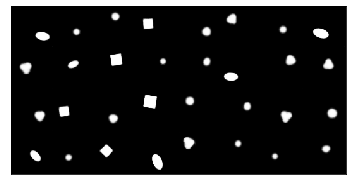

In [479]:
show(vutils.make_grid(valid_reconstructions.cpu().data))

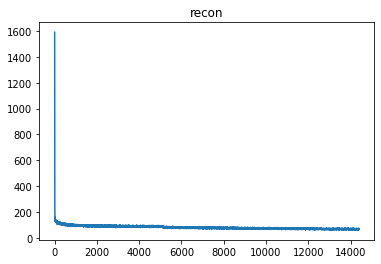

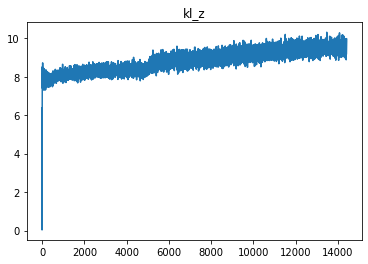

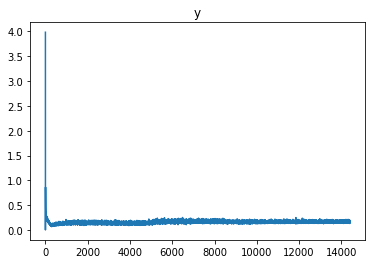

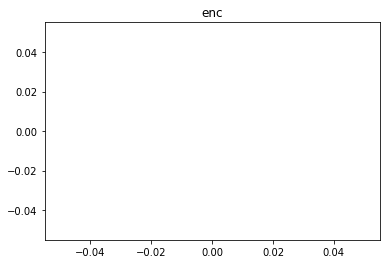

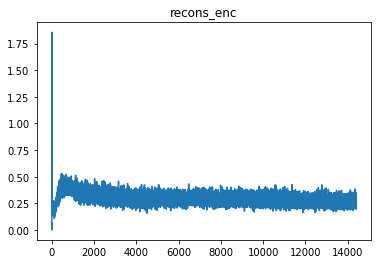

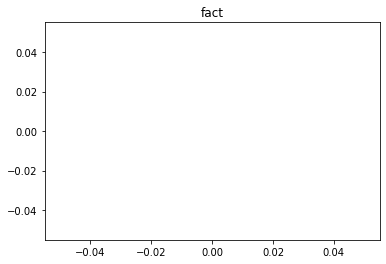

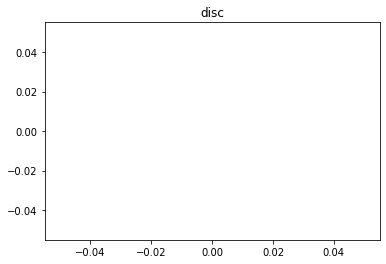

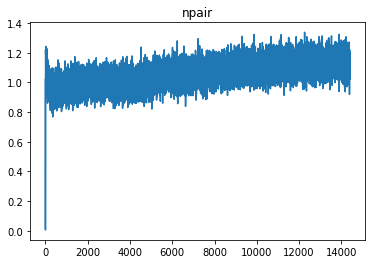

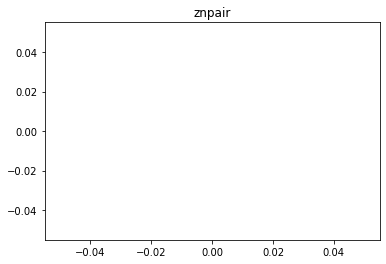

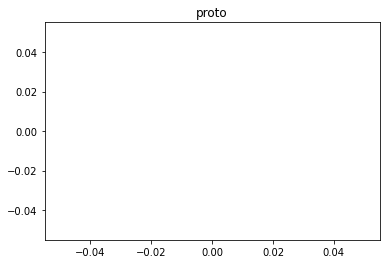

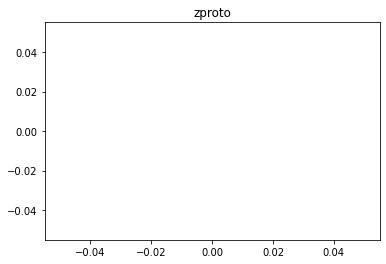

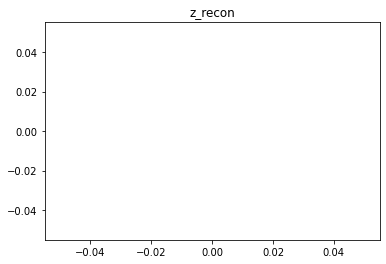

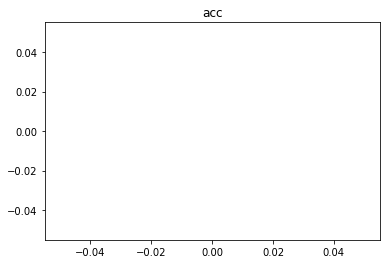

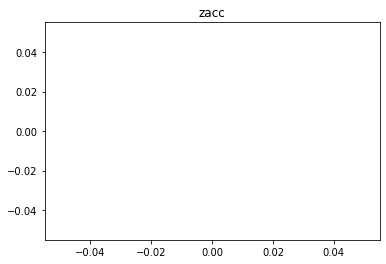

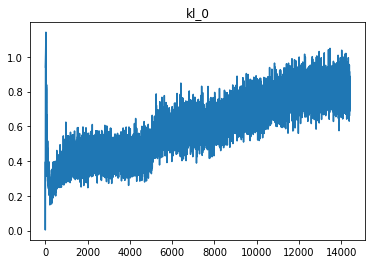

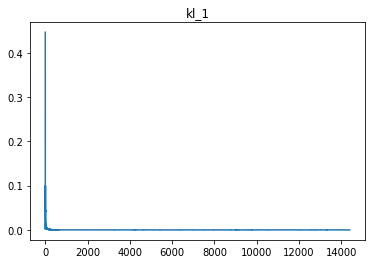

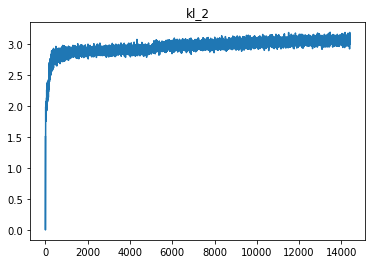

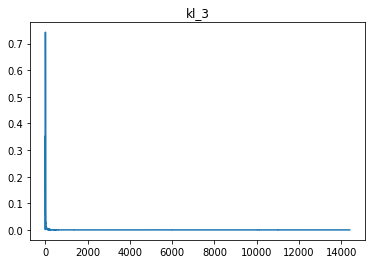

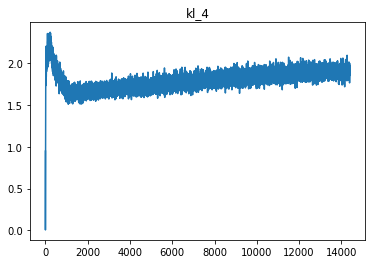

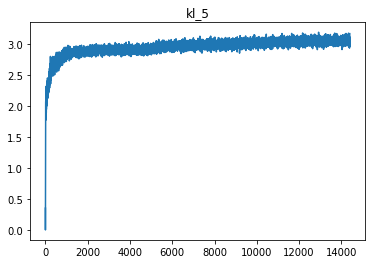

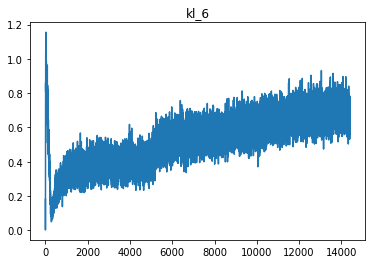

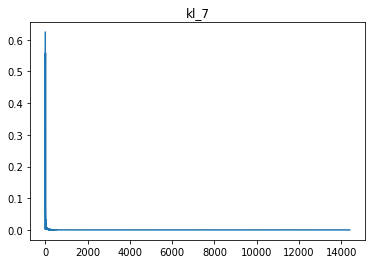

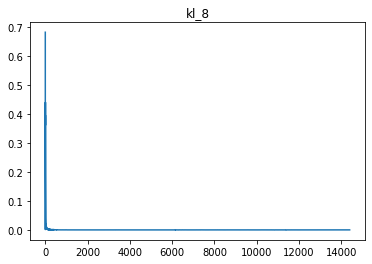

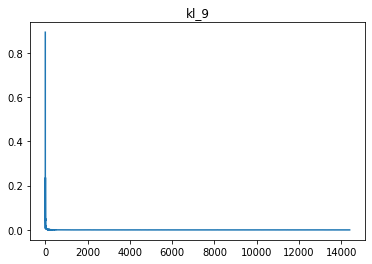

In [480]:
import json
import matplotlib.pyplot as plt

with open(loss_file) as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key][:])
    plt.title(key)
    plt.show()

In [481]:
    """Computes the npairs loss.
    Npairs loss expects paired data where a pair is composed of samples from the
    same labels and each pairs in the minibatch have different labels. The loss
    has two components. The first component is the L2 regularizer on the
    embedding vectors. The second component is the sum of cross entropy loss
    which takes each row of the pair-wise similarity matrix as logits and
    the remapped one-hot labels as labels.
    Args:
    labels: 1-D tf.int32 `Tensor` of shape [batch_size/2].
    embeddings_anchor: 2-D Tensor of shape [batch_size/2, embedding_dim] for the
      embedding vectors for the anchor images. Embeddings should not be
      l2 normalized.
    embeddings_positive: 2-D Tensor of shape [batch_size/2, embedding_dim] for the
      embedding vectors for the positive images. Embeddings should not be
      l2 normalized.
    reg_lambda: Float. L2 regularization term on the embedding vectors.
    print_losses: Boolean. Option to print the xent and l2loss.
    Returns:
    npairs_loss: tf.float32 scalar.
    """

import torch
import torch.nn as nn
import torch.functional as F

def cross_entropy(logits, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(- target * F.log_softmax(logits, -1), -1))
    else:
        return torch.sum(torch.sum(- target * F.log_softmax(logits, -1), -1))


class NpairLoss(nn.Module):
    """the multi-class n-pair loss"""
    def __init__(self, l2_reg=0.02):
        super(NpairLoss, self).__init__()
        self.l2_reg = l2_reg

    def forward(self, anchor, positive, target):
        batch_size = anchor.size(0)
        target = target.view(target.size(0), 1)

        target = (target == torch.transpose(target, 0, 1)).float()
        target = target / torch.sum(target, dim=1, keepdim=True).float()

        logit = torch.matmul(anchor, torch.transpose(positive, 0, 1))
        loss_ce = cross_entropy(logit, target)
        l2_loss = torch.sum(anchor**2) / batch_size + torch.sum(positive**2) / batch_size

        loss = loss_ce + self.l2_reg*l2_loss*0.25
        return loss

IndentationError: expected an indented block (3243866989.py, line 27)

In [ ]:
# pylint: disable=line-too-long
def npairs_loss(labels, embeddings_anchor, embeddings_positive,
                reg_lambda=0.002, print_losses=False):
    
    """Computes the npairs loss.
    Npairs loss expects paired data where a pair is composed of samples from the
    same labels and each pairs in the minibatch have different labels. The loss
    has two components. The first component is the L2 regularizer on the
    embedding vectors. The second component is the sum of cross entropy loss
    which takes each row of the pair-wise similarity matrix as logits and
    the remapped one-hot labels as labels.
    Args:
    labels: 1-D tf.int32 `Tensor` of shape [batch_size/2].
    embeddings_anchor: 2-D Tensor of shape [batch_size/2, embedding_dim] for the
      embedding vectors for the anchor images. Embeddings should not be
      l2 normalized.
    embeddings_positive: 2-D Tensor of shape [batch_size/2, embedding_dim] for the
      embedding vectors for the positive images. Embeddings should not be
      l2 normalized.
    reg_lambda: Float. L2 regularization term on the embedding vectors.
    print_losses: Boolean. Option to print the xent and l2loss.
    Returns:
    npairs_loss: tf.float32 scalar.
    """


    reg_anchor = math_ops.reduce_mean(
        math_ops.reduce_sum(math_ops.square(embeddings_anchor), 1))
    reg_positive = math_ops.reduce_mean(
        math_ops.reduce_sum(math_ops.square(embeddings_positive), 1))
    l2loss = math_ops.multiply(
        0.25 * reg_lambda, reg_anchor + reg_positive, name='l2loss')

    # Get per pair similarities.
    similarity_matrix = math_ops.matmul(
      embeddings_anchor, embeddings_positive, transpose_a=False,
      transpose_b=True)

    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    lshape = array_ops.shape(labels)
    assert lshape.shape == 1
    labels = array_ops.reshape(labels, [lshape[0], 1])

    labels_remapped = math_ops.to_float(
        math_ops.equal(labels, array_ops.transpose(labels)))
    labels_remapped /= math_ops.reduce_sum(labels_remapped, 1, keepdims=True)

    # Add the softmax loss.
    xent_loss = nn.softmax_cross_entropy_with_logits(
        logits=similarity_matrix, labels=labels_remapped)
    xent_loss = math_ops.reduce_mean(xent_loss, name='xentropy')

    if print_losses:
        xent_loss = logging_ops.Print(
            xent_loss, ['cross entropy:', xent_loss, 'l2loss:', l2loss])

    return l2loss + xent_loss

In [ ]:
import numpy as np

# 3d shapes 
mig = [0.925, 0.668, 0.527, 0.597, 0.62, 0.624, 0.644, 0.606, 0.642]
dci = [0.794, 0.9749666667, 0.7083333333, 0.7763333333, 0.8053333333, 0.8226666667, 0.787, 0.8196666667, 0.8016666667]
factor = [0.887, 1, 0.837, 0.88, 0.831, 0.88, 0.834, 0.867, 0.88]
beta = [0.914, 1, 0.962, 0.849, 0.866, 0.888, 0.856, 0.88, 0.886]

mig = np.array(mig)
dci = np.array(dci)
factor = np.array(factor)
beta = np.array(beta)


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

# Plot violin plot on axes 1
ax1.violinplot(mig, showmedians=True)
ax1.set_title('MIG')

# Plot violin plot on axes 2
ax2.violinplot(factor, showmedians=True)
ax2.set_title('Factor VAE')

# Plot violin plot on axes 3
ax3.violinplot(beta, showmedians=True)
ax3.set_title('Beta VAE')

# Plot violin plot on axes 4
ax4.violinplot(dci, showmedians=True)
ax4.set_title('DCI')

ax1.grid(axis='y')
ax2.grid(axis='y')
ax3.grid(axis='y')
ax4.grid(axis='y')

ax1.xaxis.set_visible(False) 
ax2.xaxis.set_visible(False) 
ax3.xaxis.set_visible(False) 
ax4.xaxis.set_visible(False) 
 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)    

plt.show()

In [ ]:
import seaborn as sns

In [ ]:
plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

In [ ]:
a=2

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class newmodel(nn.Module):
    def __init__(self):
        super(newmodel, self).__init__()
        
        self.register_buffer('A', torch.randn(10))
        

In [ ]:
new = newmodel()

In [ ]:
new.A

In [ ]:
b = torch.randn(10)

In [ ]:
b

In [ ]:
new.A = b

In [ ]:
new.A 

In [ ]:
new.A = b.type_as(new.A)

In [ ]:
new.A

In [ ]:
dict(new.named_buffers()).keys()

In [ ]:
a

In [ ]:
new._buffers

In [ ]:
labels = torch.tensor([1,4,3,1,2,3,2,3,4,2,1,3,3,1,4,6,8,6,5,3])

In [ ]:
labels.unique()

In [ ]:
a = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])

In [ ]:
a

In [ ]:
b = torch.tensor([1,0,1])

In [ ]:
a*b.repeat(3,1)

In [ ]:
# computes the center loss
# technically you want the centers to be detached

# This is to compute the loss
def compute_center_loss(features, centers, targets):
    features = features.view(features.size(0), -1)
    target_centers = centers[targets]
    criterion = torch.nn.MSELoss()
    center_loss = criterion(features, target_centers)
    return center_loss

In [ ]:
# use this to update the centers, see how this is used in the code. 

def get_center_delta(features, centers, targets, alpha):
    # implementation equation (4) in the center-loss paper
    features = features.view(features.size(0), -1)
    targets, indices = torch.sort(targets)
    target_centers = centers[targets] # centers are aligned
    features = features[indices] # features are also aligned

    delta_centers = target_centers - features
    uni_targets, indices = torch.unique(
            targets.cpu(), sorted=True, return_inverse=True)

    uni_targets = uni_targets.to(device)
    indices = indices.to(device)

    delta_centers = torch.zeros(
        uni_targets.size(0), delta_centers.size(1)
    ).to(device).index_add_(0, indices, delta_centers)

    targets_repeat_num = uni_targets.size()[0]
    uni_targets_repeat_num = targets.size()[0]
    targets_repeat = targets.repeat(
            targets_repeat_num).view(targets_repeat_num, -1)
    uni_targets_repeat = uni_targets.unsqueeze(1).repeat(
            1, uni_targets_repeat_num)
    same_class_feature_count = torch.sum(
            targets_repeat == uni_targets_repeat, dim=1).float().unsqueeze(1)

    delta_centers = delta_centers / (same_class_feature_count + 1.0) * alpha
    result = torch.zeros_like(centers)
    result[uni_targets, :] = delta_centers
    return result

In [ ]:
labels = torch.tensor([1,2,3,2,1,2,0,4,1,2,0,2,4])

In [ ]:
targets, inds = torch.sort(labels)

In [ ]:
targets

In [ ]:
inds

In [ ]:
def center_loss(x, labels, prototypes):
   
    batch_size = x.size(0)
    num_classes = len(labels.unique())
    assert prototypes.shape[0] == num_classes
    
    
    distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, num_classes) + \
                  torch.pow(prototypes, 2).sum(dim=1, keepdim=True).expand(num_classes, batch_size).t()
    distmat.addmm_(1, -2, x, prototypes.t())

    classes = torch.arange(num_classes).long()
    classes = classes.cuda()
    labels = labels.unsqueeze(1).expand(batch_size, num_classes)
    mask = labels.eq(classes.expand(batch_size, num_classes))

    dist = distmat * mask.float()
    loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

    return loss

# is this used to update the prototypes too? maybe not because no term of alpha is present

In [ ]:
a = torch.tensor([0,1,2,3,4,5,6,7,8,9])

In [ ]:
a//5

In [ ]:
def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [ ]:
def proto_loss(z, label, prototypes):

    # find euclidean distance
    dists = euclidean_dist(z, prototypes)
    print(dists.shape) 
    
    new_dists = dists.view(z.shape[0],-1,5)
    print(new_dists.shape)
    # reshape dists and take the max from each
    #reshaped_dists = dists.view()
    
    # this one will change, get the closest prototypes from each class  
    log_p_y = F.log_softmax(-dists, dim=1)
    # calculate the actual loss (see how to calculate this)

    # based on the label select one of these
    proto_loss = -log_p_y.gather(1, label.unsqueeze(1)).squeeze().view(-1).mean()

    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, label).float().mean()

    return proto_loss, acc


In [ ]:
z = torch.randn(4,2)

In [ ]:
label = torch.tensor([0,1,0,1])

In [ ]:
prototypes = torch.randn(10,2)

In [ ]:
proto_loss(z, label, prototypes)

In [ ]:
c = torch.tensor([[0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9]])

In [ ]:
c.shape

In [ ]:
d = c.view(3,-1,5)

In [ ]:
d

In [ ]:
a,b =d.max(dim=-1)

In [ ]:
a

In [ ]:
a.shape

In [ ]:
b.shape

In [ ]:
d

In [ ]:
d

In [ ]:
b

In [ ]:
g = torch.gather(d,-1, b.unsqueeze(-1)).squeeze(-1)

In [ ]:
g

In [ ]:
g.shape

In [ ]:
g.view()

In [ ]:
x = torch.randn(4,2)

In [ ]:
b = torch.pow(x, 2).sum(dim=1, keepdim=True)

In [ ]:
b

In [ ]:
c = b.expand(4, 10)

In [ ]:
c.shape

In [ ]:
prototypes = torch.randn(10,2)

In [ ]:
new_prototypes = torch.randn(40,2)

In [ ]:
prototypes.shape

In [ ]:
torch.pow(prototypes, 2).sum(dim=1, keepdim=True).expand(10, 4) # maybe you remove the 4 here 

In [ ]:
# 4,10 is what we want

In [ ]:
torch.pow(new_prototypes, 2).sum(dim=1, keepdim=True)

In [ ]:
# change that part to this one

torch.pow(new_prototypes, 2).sum(dim=1, keepdim=True).view(4,10)

In [ ]:
prototypes.shape

In [ ]:
addmm(x, prototypes.t(), 1, -2) # okay so 

In [ ]:
# so you multiply x with the prototypes to get a 1x10 vector. batch_size, num_features batch_size, 10, num_features

# and from this 

In [ ]:
x = torch.randn(4,2)

In [ ]:
new_prototypes = torch.randn(4,10,2)

In [ ]:
torch.cdist(new_prototypes, x.unsqueeze(1)).squeeze()

In [ ]:
torch.randperm(2)

In [ ]:
a = torch.arange(16).view(-1,2)

In [ ]:
a

In [ ]:
perm = torch.cat([torch.randperm(2).view(1,-1) for i in range(8)],0)

In [ ]:
perm.shape

In [ ]:
b = torch.cat([a[i:i+1,perm[i]] for i in range(8)],0)

In [ ]:
d = torch.randperm(2)

In [ ]:
c = a[:,d]

In [ ]:
c

In [ ]:
b

In [ ]:
# memory capacity for reservoirs

def mc_k(u, y):

    """
    u: input at time step (t - k)
    y: reconstructed input using linear readout
    
    """
    
    a = np.concatenate((np.transpose(u), np.transpose(y)),0)
    
    return np.square(np.cov(a)[0,1])/(np.var(u)* np.var(y))
    
    
def memory_capacity(input_mat, states_mat):
    """
    input_mat:  U (Kxt) with u(i) (dim K) as column i 
    states_mat: X (Nxt) where x(i) (dim N) as column i
    
    returns mc:    MC for timestep t
    """
    # calculates the pseudo inverse to get 
    X = np.linalg.pinv(states_mat)
    
    U = input_mat
    # the current state vector being x(t)
    x = states_mat[:,-1:]
    
    W = np.matmul(U, X)
    
    
    # num timesteps
    t = np.shape(states_mat)[1]
    
    mc = 0
    for i in range(1, t):

        u = U[:,-i-1:-i]

        y = np.matmul(W, x)
        
        mc += mc_k(u, y)
    
    return mc
    

In [ ]:
# test: K=4, t=10, N=20

u = np.arange(40).reshape(4,10)

X = np.arange(200).reshape(20,10)

memory_capacity(u, X)

In [ ]:
x = np.asarray([-2.1, -1,  4.3]).reshape(3,1)
y = np.asarray([3,  1.1,  0.12]).reshape(3,1)

In [ ]:
X = np.concatenate((x, y), axis=1)

In [ ]:
X.shape

In [ ]:
np.cov(X)

In [ ]:
np.cov(x,y)

In [ ]:
np.var(x)

In [ ]:
np.var(np.transpose(x))

In [ ]:
# my_list = ['apples', 'bananas', 'oranges']

In [ ]:
# for fruit in my_list:
#     print(fruit)
#     print('this fruit has been printed')

In [ ]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [ ]:
output.shape

In [482]:
print(torch.randperm(4))

tensor([3, 0, 1, 2])
